### Table of Contents

* [Load Data](#load_data)
    * [Result](#load_data_result)
* [EDA](#eda)
    * [Result](#eda_result)
        * [flight data](#eda_result_flight_date)
        * [airline](#eda_result_airline)
        * [arrival](#eda_result_arrival)
* [Preprocessing](#preprocessing)
    * [Feature Engineering](#feature_engineering)
    * [Feature Selection](#feature_selection)
        * [First Attempt](#first_attempt)
        * [SFS(Sequential Feature Selection)](#sfs)
* [Model Selection](#model_selection)
* [Hyper Parameter Tunning](#hp_tunning)
    * [Tunning Method](#tunning_method)
    * [Results](#results)
* [Results](#results)
    * [Performance](#performance)
* [Further Thoughts](#further_thoughts)

    

In [ ]:
import pandas as pd

# Load Data <a class="anchor" id="load_data"></a>

Load the data to take a look of the original data.
We found that there is also `Cancelled` flight by column `delay_time` which was expected to be `float` or `int`.
Change `Cancelled` value to `9999` to make `delay_time` able to convert to `float`.

## Result <a class="anchor" id="load_data_result"></a>

- Changed column `delay_time`'s `Cancelled` value to `9999`
- Temporarily devide data into three types: `on_time`, `delayed`, `cancelled`.
- Convert `is_claim` colume to category column because it contains only two values `0`, `800`.
- Label encode `Arrival`, `Airline`.
- Data is imbalanced.

In [ ]:
df = pd.read_csv("flight_delays_data.csv", parse_dates=[8])
df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899114 entries, 0 to 899113
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   flight_id    899114 non-null  int64         
 1   flight_no    899114 non-null  object        
 2   Week         899114 non-null  int64         
 3   Departure    899114 non-null  object        
 4   Arrival      899114 non-null  object        
 5   Airline      897400 non-null  object        
 6   std_hour     899114 non-null  int64         
 7   delay_time   899114 non-null  object        
 8   flight_date  899114 non-null  datetime64[ns]
 9   is_claim     899114 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 68.6+ MB


In [ ]:
df.delay_time.unique()

array(['0.4', '0.5', '0.0', '0.1', '0.2', '0.3', '0.9', '0.8', '-0.1',
       '1.0', '0.7', '-0.2', '2.4', '0.6', '1.2', '1.4', '1.5',
       'Cancelled', '-0.3', '2.3', '1.7', '3.7', '1.1', '3.8', '1.8',
       '5.4', '1.3', '-0.4', '2.2', '2.6', '16.2', '1.9', '1.6', '5.1',
       '4.8', '-0.7', '3.2', '2.1', '-9.3', '-8.0', '15.8', '2.0', '-7.0',
       '16.0', '3.9', '6.5', '3.5', '3.0', '-3.7', '5.3', '5.0', '2.7',
       '3.4', '5.7', '4.0', '-0.5', '2.8', '3.3', '-7.2', '-9.9', '3.6',
       '3.1', '7.5', '-8.2', '2.9', '2.5', '8.6', '6.8', '5.9', '4.7',
       '-13.9', '5.8', '12.8', '-8.1', '11.0', '-12.4', '10.6', '22.7',
       '18.3', '9.1', '-7.6', '7.8', '-6.6', '15.9', '16.1', '4.1',
       '12.0', '4.3', '4.4', '8.9', '6.0', '6.9', '7.9', '4.5', '-7.9',
       '17.0', '7.4', '7.1', '5.5', '6.4', '-7.7', '12.2', '-6.2', '11.9',
       '23.9', '4.9', '-10.8', '4.6', '9.8', '9.7', '16.8', '-1.6',
       '-12.7', '6.1', '8.7', '6.2', '12.6', '9.9', '17.6', '-7.8',
       '-

In [ ]:
# consider sampling method
df.is_claim.value_counts()

NameError: name 'df' is not defined

Then, label encode the categorical data and separate `flight_date` into three columns `flight_year`, `flight_month`, `flight_day`
I added a binary category column `label` from `is_claim`.

In [ ]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()
df["Arrival_enc"] = le.fit_transform(df["Arrival"])
df["Airline_enc"] = le.fit_transform(df["Airline"])

In [ ]:
df["flight_year"] = df["flight_date"].apply(lambda x: x.year)
df["flight_month"] = df["flight_date"].apply(lambda x: x.month)
df["flight_day"] = df["flight_date"].apply(lambda x: x.day)

df["delay_time"] = df["delay_time"].apply(lambda x: 9999 if x == "Cancelled" else float(x))

df["label"] = df["is_claim"].apply(lambda x: True if x != 0 else False)

In [ ]:
df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,73,110,2016,7,1,False
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,140,26,2015,4,23,False
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,94,85,2014,4,8,False


# EDA <a class="anchor" id="eda"></a>

Here we will focus on three columns `flight_date`, `Airline`, `Arrival`. Also attempt to add more feature.

## Result <a class="anchor" id="eda_result"></a>

### flight date

Below figure shows that cancelled and delayed flights happens more on second half year of 2015
and a massive delayed on Jan. 2015.
Then we make statistic columns `flight_date_count`, `flight_date_count_delayed`, `flight_date_count_cancelled`, `flight_date_delayed_ratio`

### airline

There are some specific airlines that has a higher chance of delay and cancel, there is also some airlines that have relatively higher chance of on-time such as `JL`.
Make statistic columns `airline_count`, `airline_count_delayed`, `airline_count_cancelled`, `airline_delayed_ratio`

### arrival

We have some arrivals that has a higher chance to delay such as `CTU`
Make statistic columns `arrival_count`, `arrival_count_delayed`, `arrival_count_cancelled`, `arrival_delayed_ratio`

In [ ]:
corr = df.corr()
corr.style.background_gradient()

,flight_id,Week,std_hour,delay_time,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label
flight_id,1.000000,-0.000409,-0.000416,0.000650,-0.000041,0.001616,-0.001176,0.000569,-0.000473,0.000615,-0.000041
Week,-0.000409,1.000000,-0.000176,0.000285,-0.014874,-0.000057,0.001449,-0.428666,0.996447,0.096420,-0.014874
std_hour,-0.000416,-0.000176,1.000000,0.001303,-0.000481,-0.029533,0.019807,-0.003853,-0.000176,-0.000377,-0.000481
delay_time,0.000650,0.000285,0.001303,1.000000,0.801306,0.000751,0.023776,0.015390,0.001405,-0.010365,0.801306
is_claim,-0.000041,-0.014874,-0.000481,0.801306,1.000000,0.011480,0.017709,0.030985,-0.014816,0.001088,1.000000
Arrival_enc,0.001616,-0.000057,-0.029533,0.000751,0.011480,1.000000,-0.042319,-0.027319,-0.000035,0.000072,0.011480
Airline_enc,-0.001176,0.001449,0.019807,0.023776,0.017709,-0.042319,1.000000,-0.004888,0.001485,-0.000596,0.017709
flight_year,0.000569,-0.428666,-0.003853,0.015390,0.030985,-0.027319,-0.004888,1.000000,-0.431298,-0.003407,0.030985
flight_month,-0.000473,0.996447,-0.000176,0.001405,-0.014816,-0.000035,0.001485,-0.431298,1.000000,0.014613,-0.014816
flight_day,0.000615,0.096420,-0.000377,-0.010365,0.001088,0.000072,-0.000596,-0.003407,0.014613,1.000000,0.001088


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataframe_dict = {
    "On-time": df[df.delay_time < 3],
    "Delayed": df[(df.delay_time >= 3)&(df.delay_time != 9999)],
    "Cancelled": df[df.delay_time == 9999]
}

In [ ]:
def value_count_plot(item: tuple, value_columns: list, axis_index: int):
    (key, dataframe) = item
    default_col = ['delay_time']
    columns = default_col + value_columns
    df = dataframe[columns].groupby(value_columns).count()
    df.plot(ax=ax[axis_index])

    ax[axis_index].legend([key])
    for idx, row in df.reset_index().sort_values(by=default_col, ascending=False).head().iterrows():
        if len(value_columns) == 1:
            ax[axis_index].annotate("({x}, {y})".format(x=row.loc[value_columns].values, y=row.loc[default_col].values), (idx+1, row.loc[default_col].values))
        else:
            ax[axis_index].annotate("({x}, {y})".format(x=row.loc[value_columns[0]], y=row.loc[value_columns[1]]), (idx-1, row.loc[default_col].values))


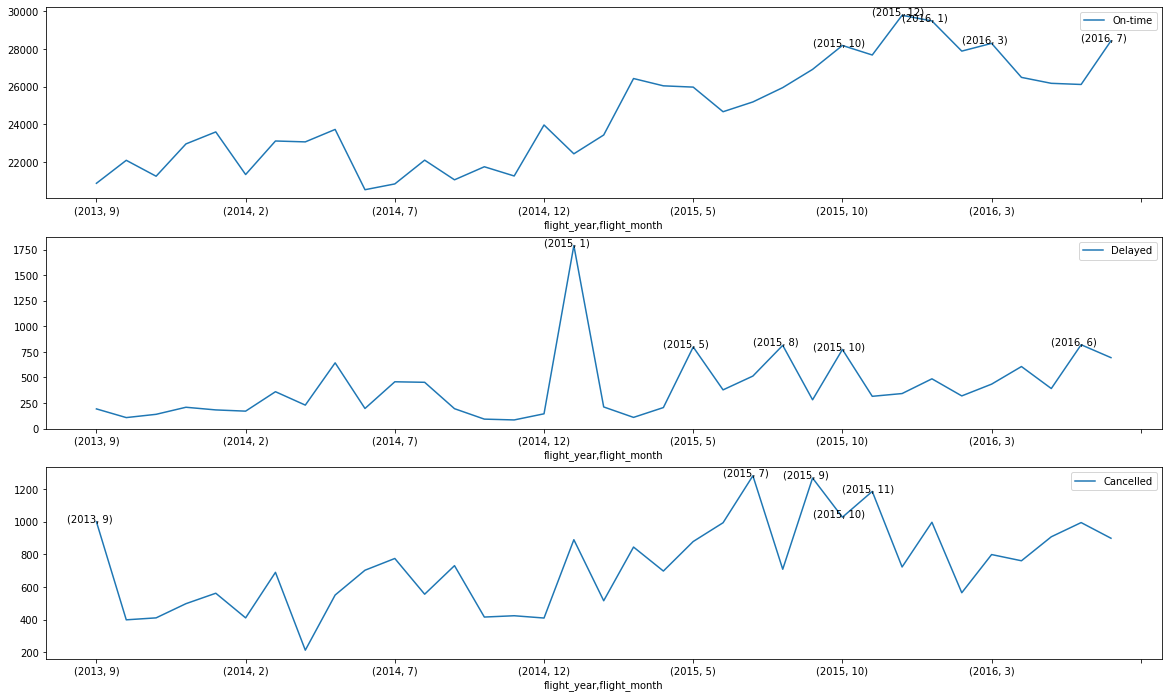

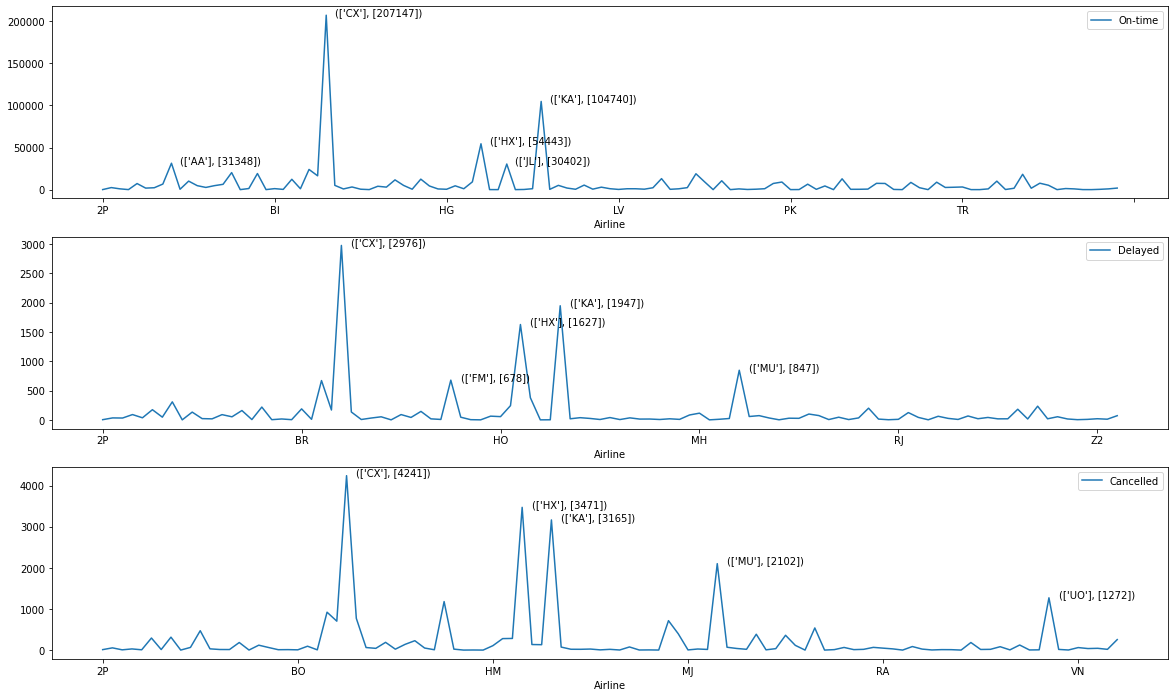

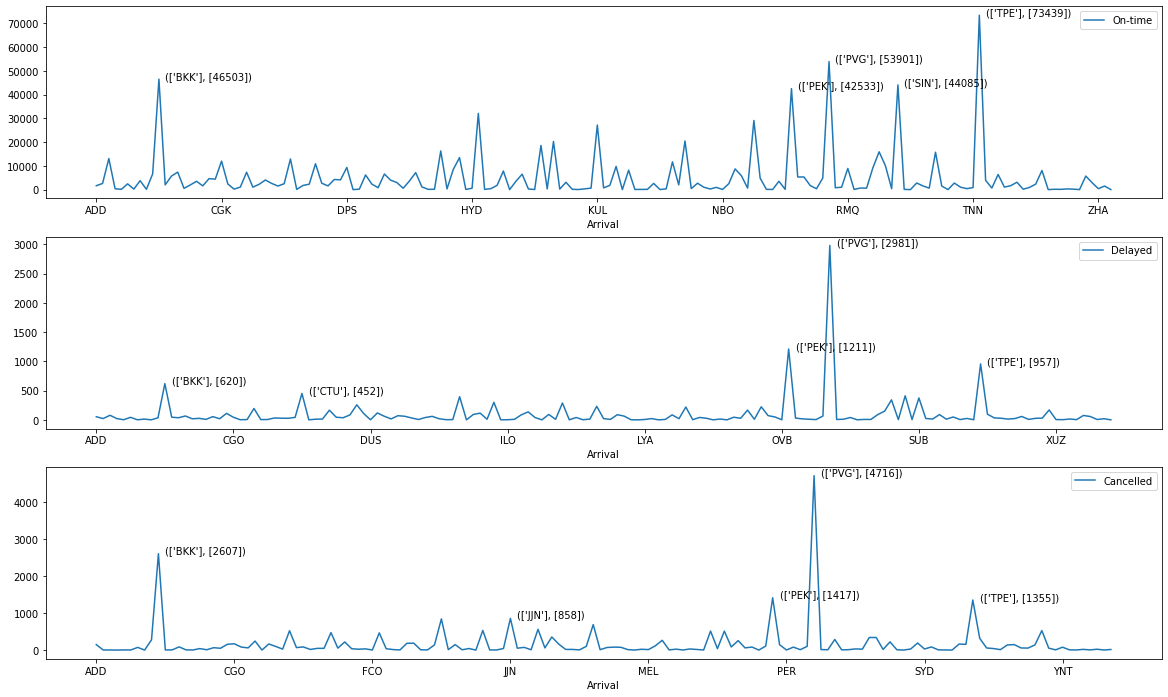

In [ ]:

for col in [['flight_year', 'flight_month'], ['Airline'], ['Arrival']]:
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

    count = 0
    for item in dataframe_dict.items():
        value_count_plot(item=item, value_columns=col, axis_index=count)
        count += 1

## Add statistics features to dataframe

In [ ]:
def add_statistic_features(dataframe, dataframe_dict, process_col):
    default_col = "delay_time"
    df = dataframe[[process_col, default_col]].groupby(process_col).count().rename(columns={default_col: f"{process_col}_count"})
    for key, val in dataframe_dict.items():
        if key in ["Cancelled", "Delayed"]:
            summary_df = dataframe_dict[key][[process_col, default_col]].groupby([process_col]).count().rename(columns={default_col: f"{process_col}_count"})
            df = df.join(summary_df, how='left', rsuffix=f'_{key.lower()}').fillna(0)
    df[f'{process_col}_delayed_ratio'] = (df[f"{process_col}_count_delayed"] + df[f"{process_col}_count_delayed"]) / df[f"{process_col}_count"]
    dataframe = dataframe.merge(df, left_on=process_col, right_index=True)
    return dataframe
    

In [ ]:
for col in ['flight_date', 'Airline', 'Arrival']:
    df = add_statistic_features(df, dataframe_dict, col)
df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,...,flight_date_count_cancelled,flight_date_delayed_ratio,Airline_count,Airline_count_delayed,Airline_count_cancelled,Airline_delayed_ratio,Arrival_count,Arrival_count_delayed,Arrival_count_cancelled,Arrival_delayed_ratio
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,...,13.0,0.025237,19718,234.0,1272.0,0.023735,20913,289.0,355.0,0.027638
283944,883183,UO1844,27,HKG,KIX,UO,14,0.7,2016-07-01,0,...,13.0,0.025237,19718,234.0,1272.0,0.023735,20913,289.0,355.0,0.027638
529472,1647660,UO1872,27,HKG,KIX,UO,10,0.2,2016-07-01,0,...,13.0,0.025237,19718,234.0,1272.0,0.023735,20913,289.0,355.0,0.027638


In [ ]:
df.columns

Index(['flight_id', 'flight_no', 'Week', 'Departure', 'Arrival', 'Airline',
       'std_hour', 'delay_time', 'flight_date', 'is_claim', 'Arrival_enc',
       'Airline_enc', 'flight_year', 'flight_month', 'flight_day', 'label',
       'flight_date_count', 'flight_date_count_delayed',
       'flight_date_count_cancelled', 'flight_date_delayed_ratio',
       'Airline_count', 'Airline_count_delayed', 'Airline_count_cancelled',
       'Airline_delayed_ratio', 'Arrival_count', 'Arrival_count_delayed',
       'Arrival_count_cancelled', 'Arrival_delayed_ratio'],
      dtype='object')

In [ ]:
corr = df.corr()
corr.style.background_gradient()

,flight_id,Week,std_hour,delay_time,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label,flight_date_count,flight_date_count_delayed,flight_date_count_cancelled,flight_date_delayed_ratio,Airline_count,Airline_count_delayed,Airline_count_cancelled,Airline_delayed_ratio,Arrival_count,Arrival_count_delayed,Arrival_count_cancelled,Arrival_delayed_ratio
flight_id,1.000000,-0.000464,-0.000312,0.000732,0.000027,0.001506,-0.000990,0.000615,-0.000523,0.000539,0.000027,0.000005,0.000177,-0.000710,0.000143,-0.000091,-0.000318,-0.000339,-0.000426,-0.000242,0.000172,0.000010,-0.001002
Week,-0.000464,1.000000,-0.000044,0.000280,-0.014885,0.000022,0.001193,-0.428646,0.996448,0.096430,-0.014885,-0.175058,-0.099903,-0.011956,-0.101357,0.001404,-0.001725,-0.003025,-0.014753,-0.010123,-0.023693,-0.021936,-0.023012
std_hour,-0.000312,-0.000044,1.000000,0.001467,-0.000237,-0.027307,0.015700,-0.004458,-0.000042,-0.000365,-0.000237,0.000190,-0.001097,-0.000624,-0.001138,-0.099024,-0.095395,-0.089629,0.004921,-0.011915,0.003334,0.009017,-0.031810
delay_time,0.000732,0.000280,0.001467,1.000000,0.801199,0.000331,0.024137,0.015497,0.001396,-0.010313,0.801199,0.017011,0.021108,0.124219,0.020342,-0.024942,-0.007462,0.017009,0.115553,0.019212,0.072292,0.092227,0.081139
is_claim,0.000027,-0.014885,-0.000237,0.801199,1.000000,0.011010,0.018209,0.031114,-0.014830,0.001115,1.000000,0.022983,0.163859,0.125501,0.164204,-0.021949,-0.001565,0.022214,0.137825,0.031755,0.102499,0.113622,0.129343
Arrival_enc,0.001506,0.000022,-0.027307,0.000331,0.011010,1.000000,-0.036466,-0.026731,0.000043,0.000095,0.011010,-0.017722,-0.005054,-0.008007,-0.004308,0.042548,0.069425,0.084796,0.131872,0.369750,0.303862,0.127932,0.169542
Airline_enc,-0.000990,0.001193,0.015700,0.024137,0.018209,-0.036466,1.000000,-0.004919,0.001228,-0.000593,0.018209,-0.002028,-0.000928,-0.001071,-0.000764,-0.368151,-0.342894,-0.280989,-0.033424,-0.030649,-0.041516,-0.014201,-0.026098
flight_year,0.000615,-0.428646,-0.004458,0.015497,0.031114,-0.026731,-0.004919,1.000000,-0.431276,-0.003427,0.031114,0.825432,0.167709,0.238264,0.127139,-0.009914,-0.006592,-0.003141,0.002104,-0.023694,-0.018637,-0.010336,-0.002680
flight_month,-0.000523,0.996448,-0.000042,0.001396,-0.014830,0.000043,0.001228,-0.431276,1.000000,0.014624,-0.014830,-0.179298,-0.105377,-0.003523,-0.107165,0.001312,-0.001863,-0.003196,-0.014971,-0.010307,-0.024017,-0.022304,-0.023234
flight_day,0.000539,0.096430,-0.000365,-0.010313,0.001115,0.000095,-0.000593,-0.003427,0.014624,1.000000,0.001115,0.021028,0.059422,-0.080522,0.065071,0.001141,0.001565,0.001828,0.001887,0.002541,0.003433,0.003757,0.001953


# Model Selection <a class="anchor" id="model_selection"></a>

I want to deploy a highly interpretative model as fast as possible.
So, tree based method comes to my mind.
I choose xgboost as a result.

# Preprocessing <a class="anchor" id="preprocessing"></a>
After adding some columns, now starting transform these columne to useable state also pop the columns not going to use for training.

## Feature Engineering <a class="anchor" id="feature_engineering"></a>
- We will pop columns that we dont need like: `flight_id`, `flight_no`, `Departure`, `Arrival`, `Airline`, `is_claim`, `flight_date`
- Apply standard scale transform on numerical columns.

In [ ]:
df.pop("flight_id")
df.pop("flight_no")
df.pop("Departure")
df.pop("Arrival")
df.pop("Airline")
df.pop("is_claim")
df.pop("flight_date")
df.pop("delay_time")
label = df.pop("label")
data = df

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# these are columns that not doing standard scaling
non_std_enc_cols = ["Week", "Arrival_enc", "Airline_enc", "flight_year", "flight_month", "flight_day"]
# for col in non_std_enc_cols:
#     data[col] = data[col].astype('category')

In [ ]:
scaler = StandardScaler()
data[data.columns[~data.columns.isin(non_std_enc_cols)]] = scaler.fit_transform(data[data.columns[~data.columns.isin(non_std_enc_cols)]])

In [ ]:
data.head(3)

,Week,std_hour,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,flight_date_count,flight_date_count_delayed,flight_date_count_cancelled,flight_date_delayed_ratio,Airline_count,Airline_count_delayed,Airline_count_cancelled,Airline_delayed_ratio,Arrival_count,Arrival_count_delayed,Arrival_count_cancelled,Arrival_delayed_ratio
0,27,-0.727183,73,110,2016,7,1,0.972644,-0.064276,-0.64641,-0.10204,-0.677813,-0.791803,-0.317705,-0.42086,-0.234256,-0.274999,-0.381789,-0.14729
283944,27,-0.003418,73,110,2016,7,1,0.972644,-0.064276,-0.64641,-0.10204,-0.677813,-0.791803,-0.317705,-0.42086,-0.234256,-0.274999,-0.381789,-0.14729
529472,27,-0.727183,73,110,2016,7,1,0.972644,-0.064276,-0.64641,-0.10204,-0.677813,-0.791803,-0.317705,-0.42086,-0.234256,-0.274999,-0.381789,-0.14729


## Feature Selection <a class="anchor" id="feature_selection"></a>

Try to create a list of valuable columns for trainning.
1. Use all the columns first to check if these features is able to work with models I am about to use.
2. Use some method to select a list of valuable features.

### First attempt <a class="anchor" id="first_attempt"></a>

We can see that the True(is delayed flight) label's performance is bad, so 
1. do feature selection to narrow down the training features.
2. consider sampling to make two label balance or use stratified sampling.

In [ ]:
from tpot import TPOTClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
train_config = {
    "n_estimators": 10,
    "max_depth": 6,
    "learning_rate": 0.1,
}
def custom_training_pack(data, n_estimators: int=10, max_depth: int=6, learning_rate: float=0.1):
    """
    This function trains a XGBClassifier
    Params:
        data: the training data
        n_estimators: epochs the model to be trained
        max_depth: tree depth of the model
        learning_rate: learning rate of the model
    Returns:
        a dictionary contains two keys: model, report
        {"model": xgb, "report": report}
    """
    len_features = len(data.columns)

    xgb = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        use_label_encoder=False,
                        n_jobs=-1,
                        verbosity=0)

    X_train, X_test, y_train, y_test = train_test_split(data,
                                                        label.values,
                                                        train_size=0.75,
                                                        test_size=0.25,
                                                        random_state=39)

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    classification_report(y_test, y_pred, output_dict=True)
    return {"model": xgb, "report": classification_report(y_test, y_pred, output_dict=True)}

In [ ]:
result = custom_training_pack(data, **train_config)
result

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=10, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=0),
 'report': {'False': {'precision': 0.959319271633184,
   'recall': 0.9987973205420448,
   'f1-score': 0.9786603329755407,
   'support': 214521},
  'True': {'precision': 0.7422577422577422,
   'recall': 0.07559263404212026,
   'f1-score': 0.13721144967682364,
   'support': 9829},
  'accuracy': 0.9583507911745042,


We can see that the True(is delayed flight) label's performance is bad, so 
1. do feature selection to narrow the training features
2. considering sampling to make two label balance 

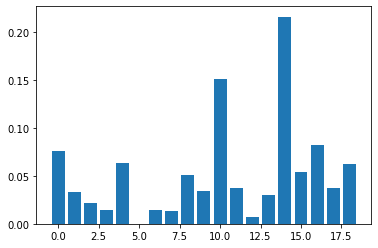

In [ ]:
%matplotlib inline
xgb = result["model"]
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [ ]:
dict(zip(data.columns, xgb.feature_importances_))

{'Week': 0.075834416,
 'std_hour': 0.033550493,
 'Arrival_enc': 0.022251878,
 'Airline_enc': 0.014135275,
 'flight_year': 0.06335708,
 'flight_month': 0.0,
 'flight_day': 0.01466029,
 'flight_date_count': 0.013146271,
 'flight_date_count_delayed': 0.05058563,
 'flight_date_count_cancelled': 0.033924796,
 'flight_date_delayed_ratio': 0.15177903,
 'Airline_count': 0.03711268,
 'Airline_count_delayed': 0.0069578346,
 'Airline_count_cancelled': 0.0303139,
 'Airline_delayed_ratio': 0.21639363,
 'Arrival_count': 0.05382569,
 'Arrival_count_delayed': 0.082746364,
 'Arrival_count_cancelled': 0.037423354,
 'Arrival_delayed_ratio': 0.06200147}

In [ ]:
# !pip install tpot mlxtend scikit-learn joblib xgboost

### SFS(Sequential Feature Selection) <a class="anchor" id="sfs"></a>

We want to chose the most representative features to take into training. So, we use sequential feature selection method to determine features.
- narrowed training features from 19 columns to 11 columns.
- overall performance improved, the f1-score goes to 0.557 to 0.567 under same training config.


In [ ]:
len_features = len(data.columns)

xgb = XGBClassifier(n_estimators=10,
                    max_depth=6,
                    learning_rate=0.1,
                    use_label_encoder=False,
                    n_jobs=-1,
                    verbosity=0)

X_train, _, y_train, _ = train_test_split(data,
                                          label.values,
                                          train_size=0.75,
                                          test_size=0.25,
                                          random_state=27)

In [ ]:
%%time
sfs = SFS(xgb,
          k_features=(1, len_features),
          forward=True,
          # floating=True,
          verbose=1,
          cv=2, # deafault using 5, changing to 2 for less computing time
          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDepr

CPU times: user 3.62 s, sys: 5.54 s, total: 9.17 s
Wall time: 14min 41s


The selected features are shown down below

In [ ]:
list(sfs.k_feature_names_)

['Week',
 'std_hour',
 'Arrival_enc',
 'flight_year',
 'flight_day',
 'flight_date_count_delayed',
 'flight_date_count_cancelled',
 'flight_date_delayed_ratio',
 'Airline_count',
 'Airline_count_delayed',
 'Arrival_count_cancelled']

In [ ]:
selected_features = list(sfs.k_feature_names_)
selected_features

['Week',
 'std_hour',
 'Arrival_enc',
 'flight_year',
 'flight_day',
 'flight_date_count_delayed',
 'flight_date_count_cancelled',
 'flight_date_delayed_ratio',
 'Airline_count',
 'Airline_count_delayed',
 'Arrival_count_cancelled']

In [ ]:
# selected_features = list(sfs.k_feature_names_)
selected_features = [
    'Week',
    'std_hour',
    'Arrival_enc',
    'flight_year',
    'flight_date_count',
    'flight_date_count_cancelled',
    'flight_date_delayed_ratio',
    'Airline_count',
    'Airline_count_cancelled',
    'Arrival_count',
    'Arrival_count_delayed',
    'Arrival_count_cancelled'
]

In [ ]:
selected_data = data[selected_features]

In [ ]:
result = custom_training_pack(selected_data, **train_config)
result

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=10, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=0),
 'report': {'False': {'precision': 0.9598356321530037,
   'recall': 0.9984803352585527,
   'f1-score': 0.9787766833684047,
   'support': 214521},
  'True': {'precision': 0.7265100671140939,
   'recall': 0.08810662325770678,
   'f1-score': 0.15715452318301423,
   'support': 9829},
  'accuracy': 0.9585959438377535,

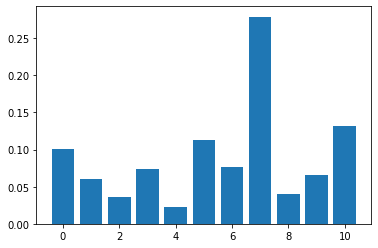

In [ ]:
%matplotlib inline
xgb = result["model"]
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [ ]:
dict(zip(data.columns, xgb.feature_importances_))

{'Week': 0.10055346,
 'std_hour': 0.06093808,
 'Arrival_enc': 0.036192425,
 'Airline_enc': 0.073689885,
 'flight_year': 0.022530084,
 'flight_month': 0.11278452,
 'flight_day': 0.077015415,
 'flight_date_count': 0.27885517,
 'flight_date_count_delayed': 0.039928477,
 'flight_date_count_cancelled': 0.06534618,
 'flight_date_delayed_ratio': 0.1321662}

# Hyper parameter tunning <a class="anchor" id="hp_tunning"></a>

Here we want to find the best parameter set for the model.

## Tunning Method <a class="anchor" id="tunning_method"></a>

I use `TPOT` to do parameter tunning, its like `GridSearch` by a given range.

- the performance have improved from 0.567 to 0.653

In [ ]:
import numpy as np

In [ ]:
tpot_config = {
    'xgboost.XGBClassifier': {
        'n_estimators': [100],
        'max_depth': range(3, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [-1],
        'verbosity': [0],
        # 'gpu_id': [0],
        # 'predictor': ['gpu_predictor']
    },
}

In [ ]:
for col in ["Week", "Arrival_enc", "flight_year", "flight_day"]:
    selected_data[col] = selected_data[col].astype("category")

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(selected_data,
                                                    label.values,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=77)
tpot_algo = TPOTClassifier(generations=3,
                           population_size=5,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           random_state=77,
                           early_stop=2,
                           verbosity=2,
                           config_dict=tpot_config)

tpot_algo.fit(X_train, y_train)
X_pre = tpot_algo.predict(X_test)
report_pre = classification_report(y_test, X_pre)

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]

/home/timsu/.local/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(



Generation 1 - Current best internal CV score: 0.24942230160546322

Generation 2 - Current best internal CV score: 0.24942230160546322


/home/timsu/.local/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/timsu/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/timsu/.local/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/timsu/.local


Generation 3 - Current best internal CV score: 0.24942230160546322

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(CombineDFs(input_matrix, input_matrix), learning_rate=1.0, max_depth=4, min_child_weight=9, n_estimators=100, n_jobs=-1, subsample=0.25, verbosity=0)
CPU times: user 7min 55s, sys: 3.76 s, total: 7min 59s
Wall time: 21min 19s


In [ ]:
model = tpot_algo.fitted_pipeline_

In [ ]:
model.named_steps

{'featureunion': FeatureUnion(transformer_list=[('functiontransformer-1',
                                 FunctionTransformer(func=<function copy at 0x7fbe0bd49670>)),
                                ('functiontransformer-2',
                                 FunctionTransformer(func=<function copy at 0x7fbe0bd49670>))]),
 'xgbclassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
               enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               learning_rate=1.0, max_delta_step=0, max_depth=4,
               min_child_weight=9, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
               predictor='auto', random_state=77, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=0.25, tree_method='exact',
               validate_par

In [ ]:
tpot_algo.export('tpot_digits_pipeline.py')

In [ ]:
%%time
model.named_steps['xgbclassifier'].set_params(n_estimators=1000,
                                              early_stopping_rounds=10)
model.fit(X_train, y_train)

/home/timsu/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 28min 56s, sys: 3.57 s, total: 29min
Wall time: 4min 8s


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7fbe0bd49670>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7fbe0bd49670>))])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree...
                               enable_categorical=False, gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=1.0, max_delta_step=0, max_depth=4,
                               min_child_weight=9, missing=nan,
                               monotone_constraints='()', n_estimator

In [ ]:
X_predict = model.predict(X_test)
X_predict_pro = model.predict_proba(X_test)

In [ ]:
classification_report(y_test, X_predict, output_dict=True)

{'False': {'precision': 0.9663158278263325,
  'recall': 0.9888933425306213,
  'f1-score': 0.977474229772531,
  'support': 214556},
 'True': {'precision': 0.5015687094750052,
  'recall': 0.24484378190729017,
  'f1-score': 0.3290566037735849,
  'support': 9794},
 'accuracy': 0.956411856474259,
 'macro avg': {'precision': 0.7339422686506689,
  'recall': 0.6168685622189558,
  'f1-score': 0.6532654167730579,
  'support': 224350},
 'weighted avg': {'precision': 0.94602729082106,
  'recall': 0.956411856474259,
  'f1-score': 0.9491675561418927,
  'support': 224350}}

# Results <a class="anchor" id="results"></a>

There are several things I did solving this problem:
1. convert the orginal data columns into useable state such as convert `delay_time` to `float` and label encode `str` category columns.
2. Add statistical features when doing EDA.
3. Decide what kind of model I am going to use based on my needs.
4. Preprocess these features into a useable state.
5. Select the really helpful features.
6. Find best oparameter set of model.

Originally, un-tunned model with all features performs bad the f1-score is `0.557`.
After narrow down the features f1-score goes to `0.567`.
Last, with selected features and tuned parameters f1-score goes to `0.653`.

# Further Thoughts <a class="anchor" id="further_thoughts"></a>
I've tried to improve the result in many ways,
First, create binary label by the `is_claim` column.
Second, use EDA result to create some statistic column.
Then, feature selection with sequential feature selection and parameter tunning.

there are several method haven't been used, such as:
- sampling method to balance the binary label
- one-hot encoding instead of label encode
- different feature selection method
- more detailed EDA like travel distance, weather, etc.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6815a8e3-a5d3-4ea2-bee4-ec093ad8a330' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>